In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [35]:
import os
if not os.path.exists('/content/A2'):
    os.makedirs('/content/A2')

In [36]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/disease/A2.zip -d /content/A2

In [37]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
!nvidia-smi

Mon Jun  3 01:22:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   76C    P0              38W /  72W |   1917MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [40]:
batch_size = 64
img_size = 224
model_type = 'A2'

data_dir = '/content/A2'

In [41]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

disease 50000
normal 50000


In [42]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize
)

dataset = datasets.ImageFolder(data_dir, ToTensor())

In [11]:
def get_norm_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for inputs, _ in dataset:
        for i in range(3):
            mean[i] += inputs[i,:,:].mean()
            std[i] += inputs[i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))

    return mean, std

In [12]:
# mean_, std_ = get_norm_std(dataset)
# print(mean_, std_)

In [13]:
# All dataset
# mean_ = (0.5589, 0.5298, 0.5114)
# std_ = (0.2119, 0.2031, 0.2015)

# imageNet
# mean_ = (0.485, 0.456, 0.406)
# std_ = (0.229, 0.224, 0.225)

# A2
# mean_ = (0.5620, 0.5327, 0.5136)
# std_ = (0.1913, 0.1865, 0.1850)

In [14]:
# transforms = Compose(
#         [
#             ToTensor(),
#             # Normalize(mean_, std_)
#         ]
#     )

In [15]:
# dataset = datasets.ImageFolder(data_dir, transforms)

In [16]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [43]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['disease', 'normal']

In [44]:
print(len(train_dataset), len(valid_dataset))

80000 20000


In [45]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

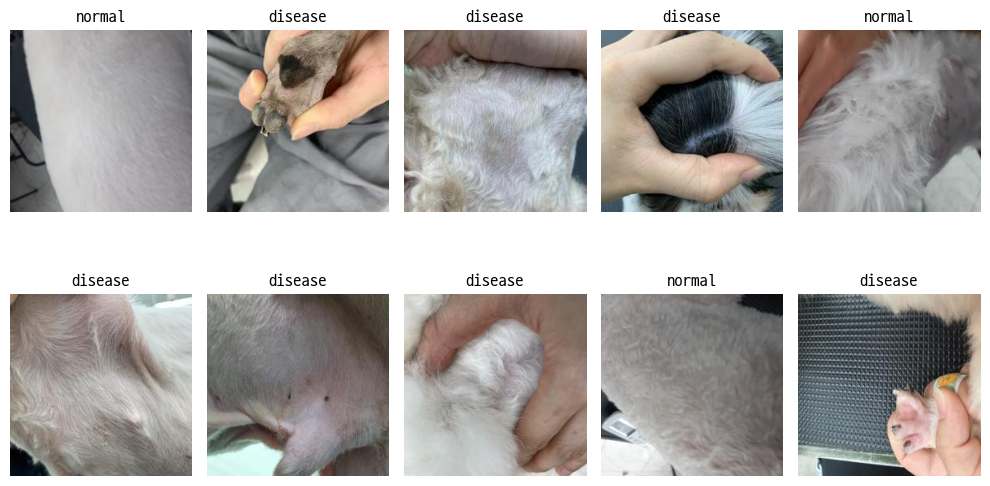

In [46]:
valid_10 = [valid_dataset[i] for i in random.sample(list(range(0, len(valid_dataset))), 10)]

fig, ax = plt.subplots(2, 5, figsize=(10, 6), tight_layout=True)

for i in range(2):
    for j in range(5):
        img = valid_10[(i*5)+j][0]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[valid_10[(i*5)+j][1]])
        ax[i][j].axis('off')

plt.show()

# Model Training

In [21]:
# inception_v4 1536
# inception_resnet_v2 1536
# resnet50 2048
# resnetv2_50 2048
# efficientnet_b0 1280
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# vit_base_resnet26d_224 768
# vit_base_resnet50d_224 768
# vit_small_resnet26d_224 768
# vit_small_resnet50d_s16_224 768

In [47]:
model_name = 'resnet101'
hidden_size = 1024
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=hidden_size)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [23]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [24]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [48]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [49]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [50]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [52]:
classifier = Classifier(model, hidden_size, num_classes=num_classes).to(device)
# classifier = model.to(device)

In [54]:
opt_name = 'AdamW'
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=0.0005)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                         factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [55]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [56]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [57]:
def load_dict(model, optimizer, lr_scheduler, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)

    return epoch, labels, model, optimizer, lr_scheduler

In [58]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [59]:
file_path = model_path

pretrained = False

In [60]:
num_epochs = 10

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}_{opt_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}_{opt_name}.pickle')

    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [61]:
print(epoch_start, best_val_acc, best_val_loss)

0 0.0 100.0


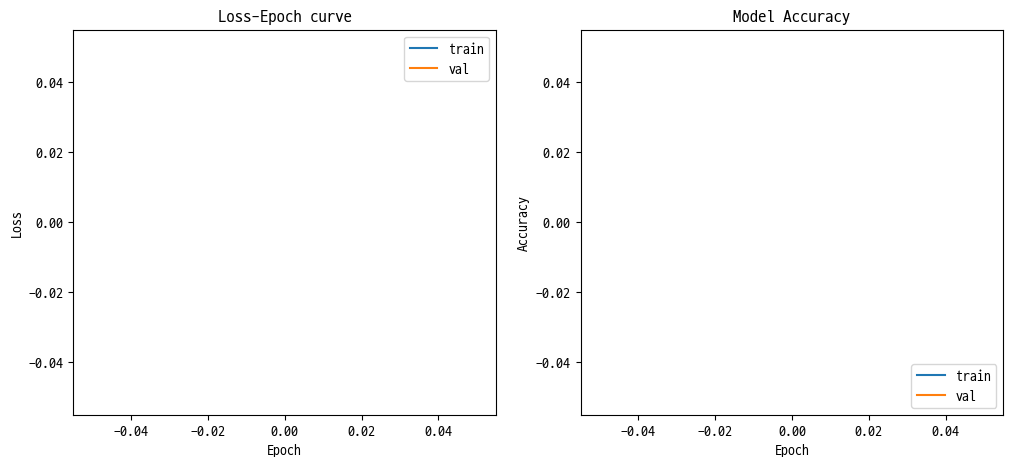

In [62]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [63]:
# epoch_start = e

epoch 3 train acc 0.7714875 validation acc 0.752745607028754


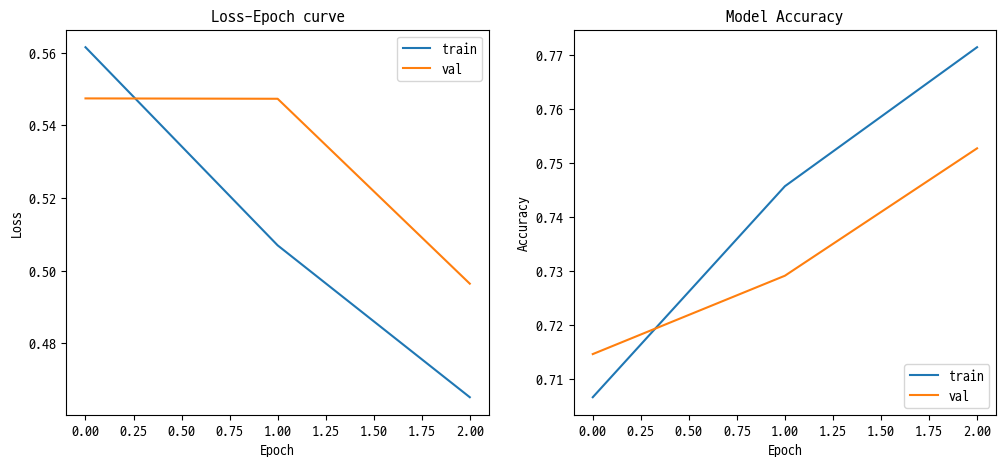

  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 4 train acc 0.8059625 loss 0.4134483341217041 lr 0.001


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 4 valid acc 0.7388178913738019 loss 0.5311498190648258


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 5 train acc 0.845525 loss 0.34185428602695467 lr 0.001


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 5 valid acc 0.7478035143769968 loss 0.5137913648884136


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 6 train acc 0.88905 loss 0.26016244060993193 lr 0.001


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 6 valid acc 0.7438099041533547 loss 0.6188185829133652


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 7 train acc 0.959075 loss 0.11299736830964685 lr 0.0005


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 7 valid acc 0.7548422523961661 loss 0.7852623720709889


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 8 train acc 0.9819875 loss 0.06198811322990805 lr 0.0005


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 8 valid acc 0.7469548722044729 loss 0.9977065658036132


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 9 train acc 0.9862 loss 0.051716631213016805 lr 0.0005


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 9 valid acc 0.7615315495207667 loss 0.9455771528113003


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 10 train acc 0.9935875 loss 0.025564236976206304 lr 0.00025


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10 valid acc 0.7660243610223643 loss 1.1448229019062968


In [64]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {} lr {}".format(e, tot_train_acc, mean_train_loss, lr))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)

    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, f"{model_name}_{opt_name}")

In [65]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                model_path, f"{model_name}_{opt_name}_{e}epoch")

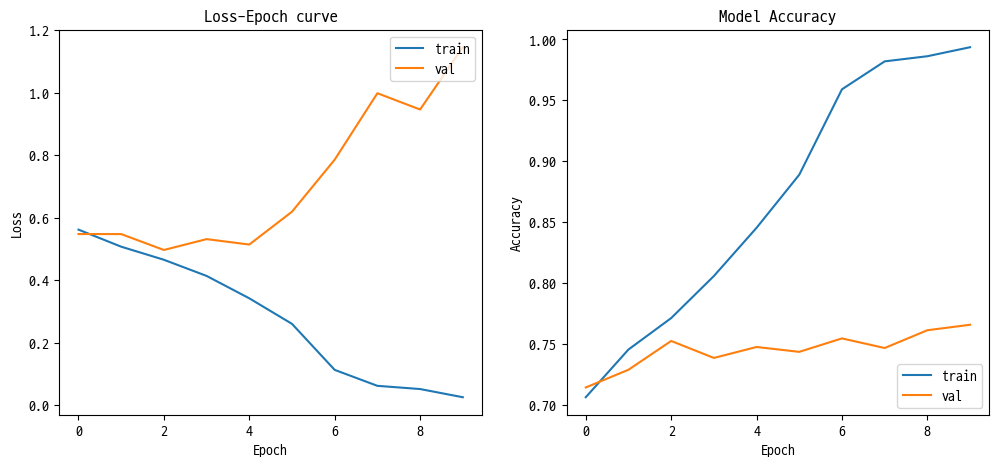

In [68]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

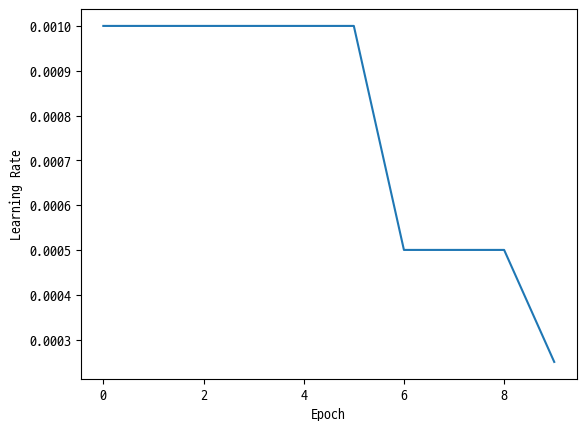

In [69]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# to .onnx

In [15]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 87.1 MB/s eta 0:00:00


In [19]:
dict_file = os.path.join(model_path, f'{model_name}_{opt_name}.pt')

pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = classifier.state_dict()
model_dict.update(state_dict)
classifier.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
classifier

In [ ]:
classifier = classifier.to(device)
classifier.eval()

In [21]:
labels

['disease', 'normal']

In [22]:
import torch.onnx

In [23]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, f'{model_name}_{opt_name}.onnx'))

# Inference

In [24]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0).to(device)

    outputs = classifier(img)
    result = outputs.softmax(1)
    # result_dict = {}

    # for i, value in enumerate(result[0].tolist()):
    #     result_dict[labels[i]] = value

    # result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return (result[0].argmax(), result[0].tolist())

In [25]:
if not os.path.exists('/content/A2_test'):
    os.makedirs('/content/A2_test')

!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/disease/test/A2_test.zip -d /content/A2_test

In [26]:
root = '/content/A2_test'

In [72]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        predictions['target'].append(folder)
        inf_result = inference(os.path.join(root, folder, file))
        predictions['pred'].append(labels[inf_result[0]])
        predictions['probs'].append(inf_result[1])
        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

disease 7849
1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
normal 9534
8000 done
9000 done
10000 done
11000 done
12000 done
13000 done
14000 done
15000 done
16000 done
17000 done


In [73]:
import json

with open(f'/content/drive/MyDrive/CV_project/skin_model/prediction/{model_type}_{model_name}_{opt_name}.json', 'w') as f:
    json.dump(predictions, f)

In [74]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, 'disease'), Text(0, 1.5, 'normal')]

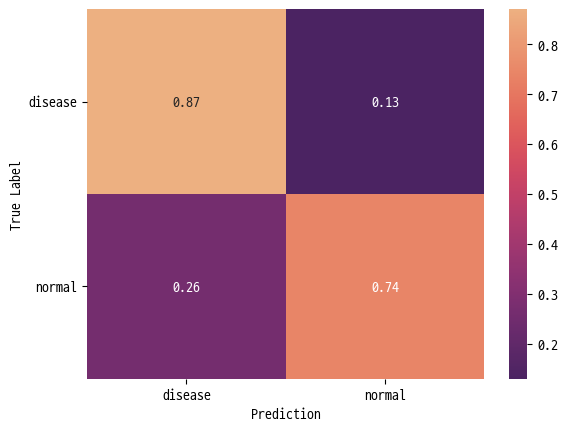

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10)
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [76]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

     disease       0.74      0.87      0.80      7849
      normal       0.87      0.74      0.80      9534

    accuracy                           0.80     17383
   macro avg       0.81      0.81      0.80     17383
weighted avg       0.81      0.80      0.80     17383



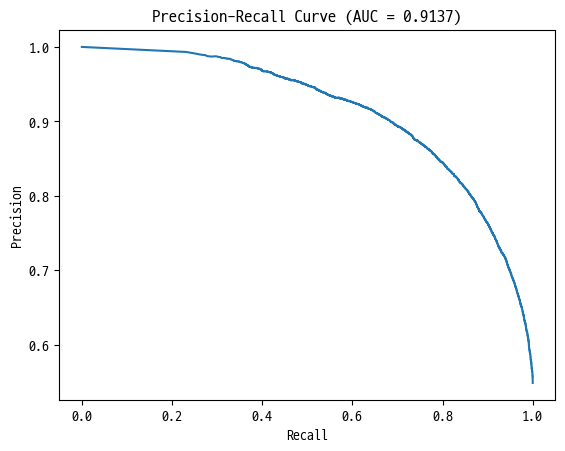

In [77]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

target = np.array(predictions['target'])
probs = np.array(predictions['probs'])[:, 1]

precision, recall, thresholds = precision_recall_curve(target, probs, pos_label='normal')
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve (AUC = ' + str(round(pr_auc,4)) + ')')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()